In [1]:
# Import Python libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
def show_image(image) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    """
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()


def draw_contour(image, contour, color):
    """
    Draws a contour on the provided image.

    Args:
        image: The image on which to draw the contour.
        contour: The contour to draw on the image.
        color: The color to draw the contour in BGR format.
    """
    cv.drawContours(image, [contour], 0, color, 3)


def draw_circle(color_image, center, color, radius = 6):
    """
    Draws a circle on the provided image.

    Args:
        color_image: The color image on which to draw the contour.
        center: The pixel (row, column) of the center of the image.
        color: The color to draw the circle in BGR format.
        radius: The radius of the circle in pixels.
    """
    # cv.circle expects the center in (column, row) format
    cv.circle(color_image, (center[1], center[0]), radius, color, -1)


def show_color_bgr(blue, green, red):
    """
    Displays a color specified in the BGR format.
    """
    rectangle = plt.Rectangle((0,0), 50, 50, fc=(red/255, green/255, blue/255))
    plt.gca().add_patch(rectangle)
    plt.show()


def show_color_hsv(hue, saturation, value):
    """
    Displays a color specified in the HSV format
    """
    # Convert from hsv to bgr
    hsv = np.array([[[hue, saturation, value]]], np.uint8)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    show_color_bgr(bgr[0][0][0], bgr[0][0][1], bgr[0][0][2])

In [58]:
image = cv.imread("../../Resources/Input and Output/output/S__31277060_denoised.jpg")

blue: 230
green: 237
red: 224


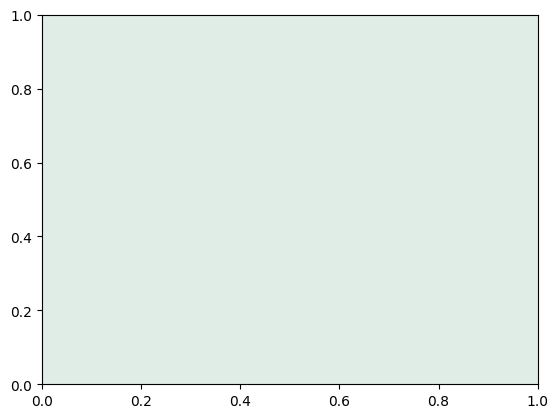

In [59]:
# Calculate center row and column
row =400
col = 800

# Extract and print blue, green, and red values
blue = image[row][col][0]
green = image[row][col][1]
red = image[row][col][2]

print("blue:", blue)
print("green:", green)
print("red:", red)

# Display this color
show_color_bgr(blue, green, red)

In [60]:
# BGR color
widgets.interact(show_color_bgr,
                 blue=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 green=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 red=widgets.IntSlider(0, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='blue', max=255), IntSlider(valu…

In [61]:
# HSV color
widgets.interact(show_color_hsv,
                 hue=widgets.IntSlider(0, 0, 180, continuous_update=False),
                 saturation=widgets.IntSlider(255, 0, 255, continuous_update=False),
                 value=widgets.IntSlider(255, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='hue', max=180), IntSlider(value…

In [64]:
def get_mask(image, hsv_lower, hsv_upper):
    """
    Returns a mask containing all of the areas of image which were between hsv_lower and hsv_upper.

    Args:
        image: The image (stored in BGR) from which to create a mask.
        hsv_lower: The lower bound of HSV values to include in the mask.
        hsv_upper: The upper bound of HSV values to include in the mask.
    """
    # Convert hsv_lower and hsv_upper to numpy arrays so they can be used by OpenCV
    hsv_lower = np.array(hsv_lower)
    hsv_upper = np.array(hsv_upper)

    # Use the cv.cvtColor function to switch our BGR colors to HSV colors
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Use the cv.inRange function to highlight areas in the correct range
    mask = cv.inRange(image, hsv_lower, hsv_upper)

    return mask

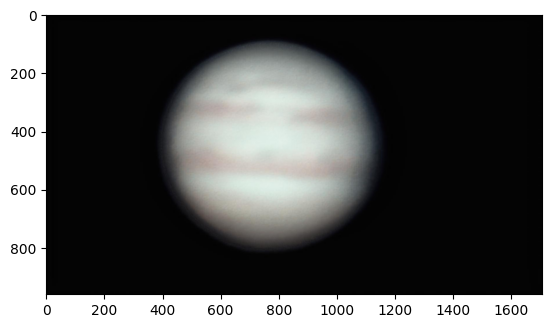

In [65]:
show_image(image)

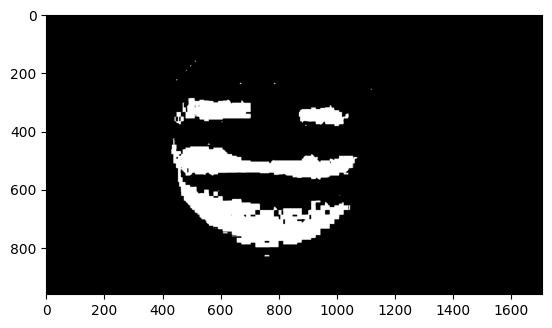

In [66]:
hsv = ((1, 0, 0), (30, 255, 255))

mask = get_mask(image, *hsv)
show_image(mask)

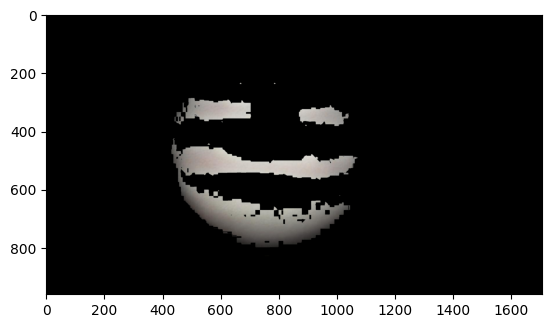

In [67]:
masked_image = cv.bitwise_and(image, image, mask=mask)

show_image(masked_image)

In [68]:
def draw_sift_kp(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(gray)
    img = cv.drawKeypoints(gray, kp, None, flags=4)
    return img

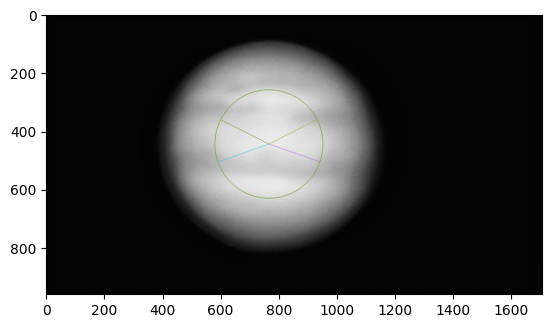

In [69]:
plt.imshow(draw_sift_kp(image))

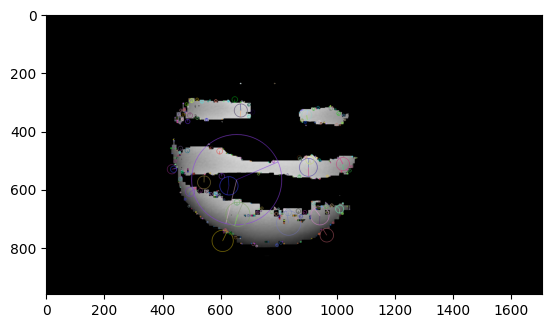

In [75]:
sift_image = draw_sift_kp(masked_image)
plt.imshow(sift_image)

In [80]:
def get_kp(image):
    """
    Returns the keypoints and descriptors of an image using SIFT feature detection.

    Args:
        image: The image to detect keypoints in.

    Returns:
        A tuple of (keypoints, descriptors) detected on the image.
    """
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # 新しいSIFT実装を使用
    sift = cv.SIFT_create()
    # detectAndCompute を使用して特徴点と特徴量記述子の両方を取得
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des

def match_kp(des1, des2):
    """
    Matches two sets of descriptors using brute-force matching with ratio test.

    Returns:
        A list of good matches between the two sets of descriptors.
    """
    # BFMatcherを作成（k近傍法を使用）
    bf = cv.BFMatcher()
    # k=2で上位2つのマッチを取得
    matches = bf.knnMatch(des1, des2, k=2)

    # Loweのratio testを適用
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # 0.75は閾値で、調整可能
            good_matches.append(m)

    return good_matches

In [81]:
def align_images(original_image1, original_image2, image1, image2):
    """
    2つの画像を位置合わせして変形させる関数

    Args:
        image1: 基準となる画像
        image2: 変形させる画像

    Returns:
        tuple: (変形後の画像, ホモグラフィー行列)
    """
    # 特徴点とディスクリプタを取得
    kp1, des1 = get_kp(image1)
    kp2, des2 = get_kp(image2)

    # 特徴点マッチング
    matches = match_kp(des1, des2)

    # マッチした特徴点の座標を抽出
    if len(matches) > 4:  # 4点以上のマッチが必要
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        # ホモグラフィー行列を計算
        H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

        if H is not None:
            # 画像を変形
            h, w = original_image1.shape[:2]
            warped_image = cv.warpPerspective(original_image2, H, (w, h))
            return warped_image, H
        else:
            raise ValueError("ホモグラフィー行列の計算に失敗しました。")
    else:
        raise ValueError("十分なマッチが見つかりませんでした。")

    return None, None

Found 42 good matches


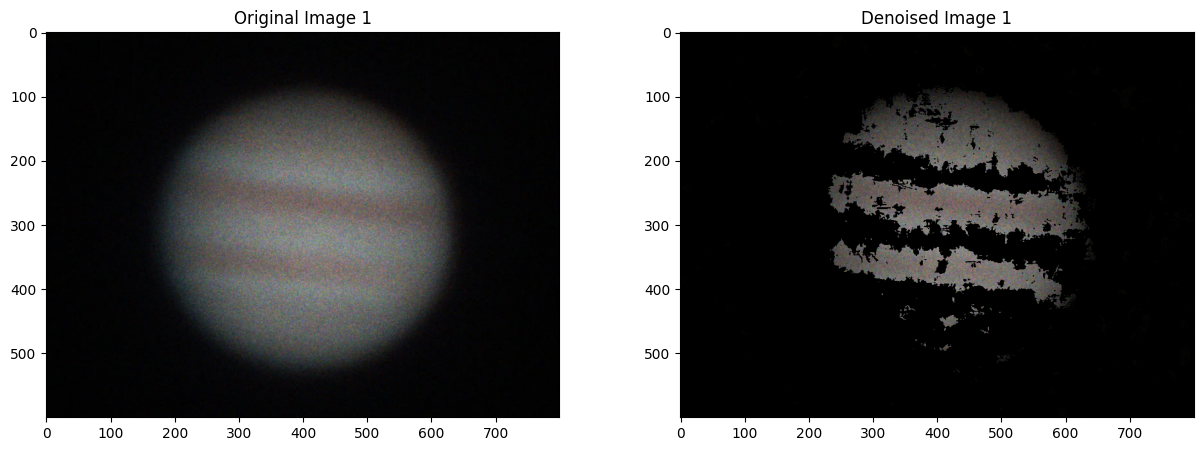

In [82]:
def denoise_image(image, method='gaussian', params=None):
    """
    画像のノイズを除去する関数

    Args:
        image: 入力画像（OpenCV形式）
        method: ノイズ除去の手法 ('gaussian', 'median', 'bilateral', 'nlmeans')
        params: ノイズ除去のパラメータ（辞書形式）
               デフォルト値は手法ごとに設定

    Returns:
        ノイズ除去された画像
    """
    if params is None:
        params = {}

    # 各手法のデフォルトパラメータ
    default_params = {
        'gaussian': {'ksize': (5,5), 'sigmaX': 0},
        'median': {'ksize': 5},
        'bilateral': {'d': 9, 'sigmaColor': 75, 'sigmaSpace': 75},
        'nlmeans': {'h': 10, 'templateWindowSize': 7, 'searchWindowSize': 21}
    }

    # パラメータの設定（指定がない場合はデフォルト値を使用）
    current_params = default_params.get(method, {})
    current_params.update(params)

    # 画像のコピーを作成
    denoised = image.copy()

    try:
        if method == 'gaussian':
            # ガウシアンフィルタ（全体的なノイズ除去）
            denoised = cv.GaussianBlur(image,
                                     current_params['ksize'],
                                     current_params['sigmaX'])

        elif method == 'median':
            # メディアンフィルタ（塩コショウノイズに効果的）
            denoised = cv.medianBlur(image,
                                   current_params['ksize'])

        elif method == 'bilateral':
            # バイラテラルフィルタ（エッジを保持しながらノイズ除去）
            denoised = cv.bilateralFilter(image,
                                        current_params['d'],
                                        current_params['sigmaColor'],
                                        current_params['sigmaSpace'])

        elif method == 'nlmeans':
            # Non-local Meansフィルタ（より高度なノイズ除去）
            denoised = cv.fastNlMeansDenoisingColored(image,
                                                     None,
                                                     current_params['h'],
                                                     current_params['h'],
                                                     current_params['templateWindowSize'],
                                                     current_params['searchWindowSize'])
        else:
            raise ValueError(f"Unknown denoising method: {method}")

    except Exception as e:
        print(f"Error during denoising: {str(e)}")
        return image

    return denoised

# 使用例
def process_images_with_denoising(image1_path, image2_path, denoise_method='bilateral'):
    """
    2つの画像をノイズ除去してから特徴点マッチングを行う

    Args:
        image1_path: 1枚目の画像パス
        image2_path: 2枚目の画像パス
        denoise_method: ノイズ除去手法
    """
    # 画像を読み込む
    image1 = cv.imread(image1_path)
    image2 = cv.imread(image2_path)

    # ノイズ除去
    image1_denoised = denoise_image(image1, method=denoise_method)
    image2_denoised = denoise_image(image2, method=denoise_method)

    mask1 = get_mask(image1_denoised, *hsv)
    mask2 = get_mask(image2_denoised, *hsv)

    masked_image1 = cv.bitwise_and(image1, image1, mask=mask1)
    masked_image2 = cv.bitwise_and(image2, image2, mask=mask2)

    # 特徴点とディスクリプタを取得
    kp1, des1 = get_kp(masked_image1)
    kp2, des2 = get_kp(masked_image2)

    # マッチング
    matches = match_kp(des1, des2)
    print(f"Found {len(matches)} good matches")

    return masked_image1, masked_image2, matches

# 使用例
image1_path = "../../Resources/Images/19_57_44/001.jpg"
image2_path = "../../Resources/Images/19_57_44/002.jpg"

# ノイズ除去を適用して特徴点マッチング
img1_denoised, img2_denoised, matches = process_images_with_denoising(
    image1_path,
    image2_path,
    denoise_method='nlmeans'
)

# 結果の表示
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Original Image 1')
plt.imshow(cv.cvtColor(cv.imread(image1_path), cv.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Denoised Image 1')
plt.imshow(cv.cvtColor(img1_denoised, cv.COLOR_BGR2RGB))
plt.show()

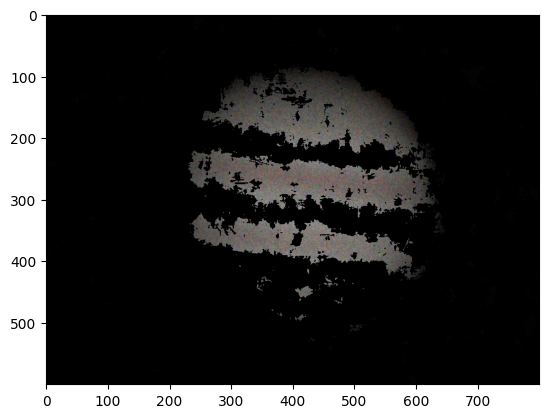

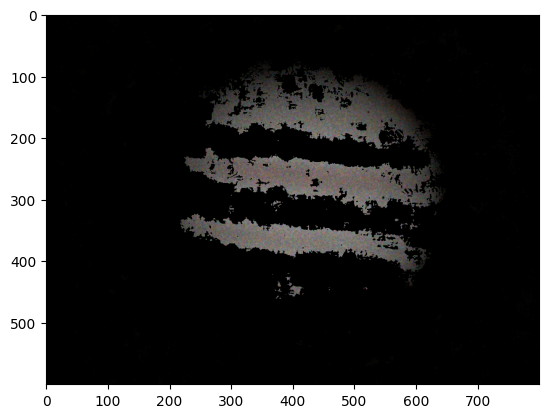

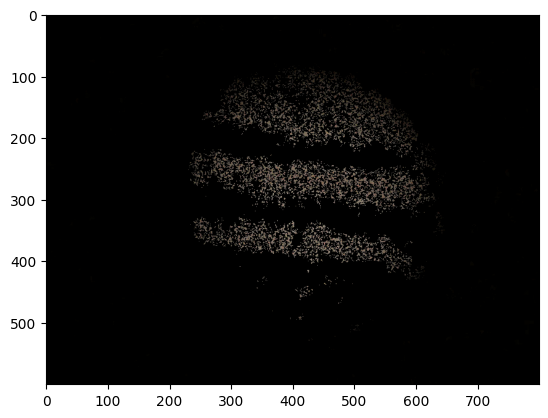

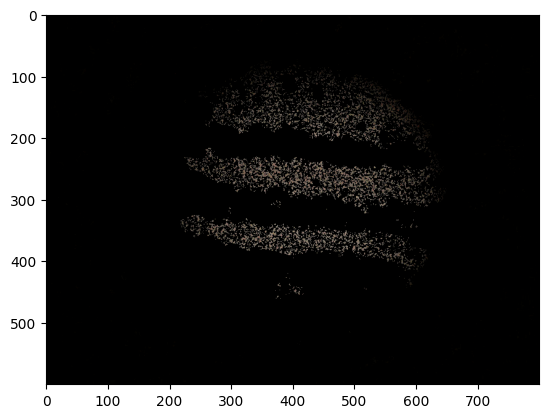

Found 42 good matches


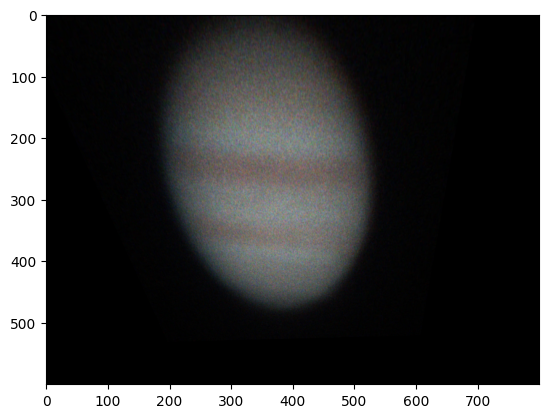

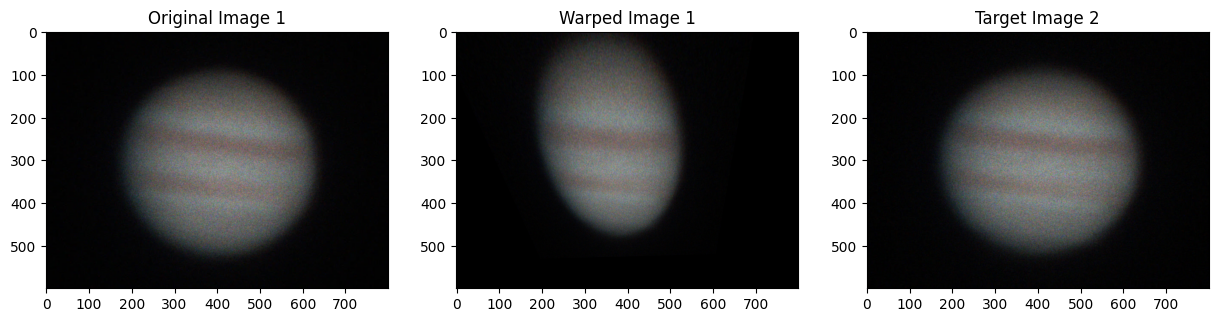

In [83]:
# マッチング結果を確認
original_image1 = cv.imread("../../Resources/Images/19_57_44/001.jpg")
original_image2 = cv.imread("../../Resources/Images/19_57_44/002.jpg")
image1 = img1_denoised
image2 = img2_denoised

show_image(image1)
show_image(image2)

mask1 = get_mask(image1, *hsv)
mask2 = get_mask(image2, *hsv)

masked_image1 = cv.bitwise_and(image1, image1, mask=mask1)
masked_image2 = cv.bitwise_and(image2, image2, mask=mask2)

show_image(masked_image1)
show_image(masked_image2)

# 特徴点と記述子を取得
kp1, des1 = get_kp(image1)
kp2, des2 = get_kp(image2)


# 記述子を使ってマッチング
matches = match_kp(des1, des2)
print(f"Found {len(matches)} good matches")

# マッチングが少なすぎる場合は警告
if len(matches) < 4:
    raise ValueError("Not enough matches found (minimum 4 required)")

warped_image, homography = align_images(original_image1, original_image2, image1, image2)
show_image(warped_image)

# 変形前後の画像を並べて表示
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title('Original Image 1')
plt.imshow(cv.cvtColor(original_image1, cv.COLOR_BGR2RGB))
plt.subplot(132)
plt.title('Warped Image 1')
plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB))
plt.subplot(133)
plt.title('Target Image 2')
plt.imshow(cv.cvtColor(original_image2, cv.COLOR_BGR2RGB))
plt.show()